<a href="https://colab.research.google.com/github/sauragr/datasciencecoursera/blob/master/animefaces.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [150]:
! pip install opendatasets
import opendatasets as od

In [151]:
dataset_url = 'https://www.kaggle.com/splcher/animefacedataset'
od.download(dataset_url)

Skipping, found downloaded files in "./animefacedataset" (use force=True to force download)


In [152]:
import os

data_dir = './animefacedataset'
print(os.listdir(data_dir))

['images']


In [153]:
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import torchvision.transforms as T

In [154]:
image_size = 64
batch_size = 128
stats = (0.5,0.5,0.5),(0.5,0.5,0.5)

In [155]:
train_ds = ImageFolder(data_dir , transform=T.Compose([
    T.Resize(image_size),
    T.CenterCrop(image_size),
    T.ToTensor(),
    T.Normalize(*stats)
]))

train_dl = DataLoader(train_ds,
                      batch_size,
                      shuffle=True,
                      num_workers=3,
                      pin_memory=True)

In [156]:
import torch
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
%matplotlib inline

In [157]:
def denorm(img_tensors):
  return img_tensors*stats[1][0]+stats[0][0]

In [158]:

def show_images(images, nmax=64):
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid(denorm(images.detach()[:nmax])).permute(1, 2, 0))

def show_batch(dl, nmax=64):
    for images, _ in dl:
        show_images(images, nmax)
        break

In [159]:
train_ds[0][0].shape

torch.Size([3, 64, 64])

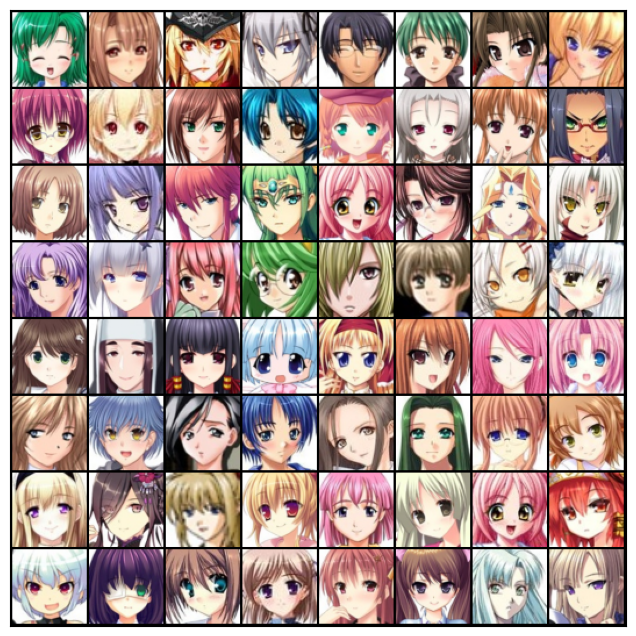

In [160]:
show_batch(train_dl,nmax=64)

In [161]:
def get_default_device():
  if torch.cuda.is_available():
    return torch.device('cuda')
  else:
    return torch.device('cpu')

def to_device(data,device):
  if isinstance(data,(list,tuple)):
    return [to_device(x,device) for x in data]
  return data.to(device,non_blocking=True)

class DeviceDataLoader():
  def __init__(self,dl,device):
    self.dl = dl
    self.device = device

  def __iter__(self):
    for b in self.dl:
      yield to_device(b,self.device)

  def __len__(self):
    return len(self.dl)

In [162]:
 device = get_default_device()
 device

device(type='cuda')

In [163]:
train_dl = DeviceDataLoader(train_dl , device)

In [164]:
import torch.nn as nn

In [165]:
discriminator = nn.Sequential(
    nn.Conv2d(3,64,kernel_size=4,stride=2,padding=1,bias=False),
    nn.BatchNorm2d(64),
    nn.LeakyReLU(0.2,inplace= True),

    nn.Conv2d(64,128,kernel_size=4,stride=2,padding=1,bias=False),
    nn.BatchNorm2d(128),
    nn.LeakyReLU(0.2,inplace=True),

    nn.Conv2d(128,256,kernel_size=4,stride=2,padding=1,bias=False),
    nn.BatchNorm2d(256),
    nn.LeakyReLU(0.2,inplace=True),

    nn.Conv2d(256,512,kernel_size=4,stride=2,padding=1,bias=False),
    nn.BatchNorm2d(512),
    nn.LeakyReLU(0.2,inplace=True),

    nn.Conv2d(512,1,kernel_size=4,stride=1,padding=0,bias=False),

    nn.Flatten(),
    nn.Sigmoid()
)

In [166]:
discriminator = to_device(discriminator,device)

In [167]:
latent_size=128

In [168]:
generator = nn.Sequential(
    nn.ConvTranspose2d(latent_size,512,kernel_size=4,stride=1,padding=0,bias=False),
    nn.BatchNorm2d(512),
    nn.ReLU(True),

    nn.ConvTranspose2d(512,256,kernel_size=4,stride=2,padding=1,bias = False),
    nn.BatchNorm2d(256),
    nn.ReLU(True),

    nn.ConvTranspose2d(256,128,kernel_size=4,stride=2,padding=1,bias= False),
    nn.BatchNorm2d(128),
    nn.ReLU(True),

    nn.ConvTranspose2d(128,64,kernel_size=4,stride=2,padding=1,bias=False),
    nn.BatchNorm2d(64),
    nn.ReLU(True),

    nn.ConvTranspose2d(64,3,kernel_size=4,stride=2,padding=1,bias=False),
    nn.Tanh()

)

torch.Size([128, 3, 64, 64])


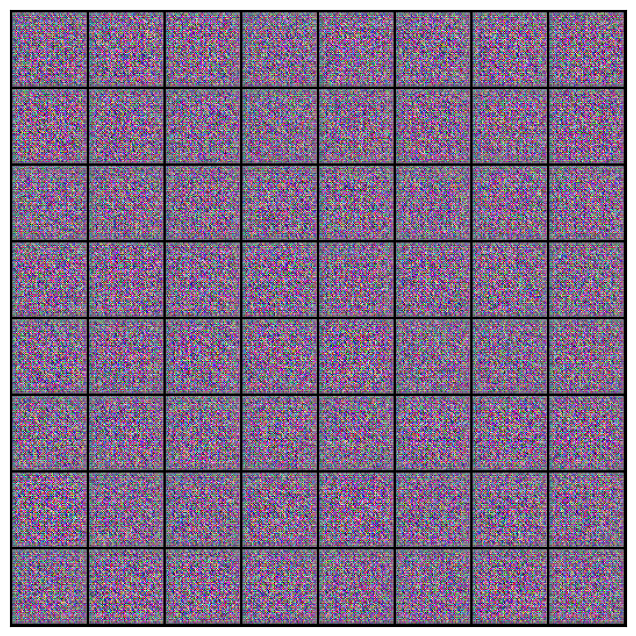

In [169]:
xb = torch.randn(batch_size,latent_size,1,1) #Random Latent Tensors
fake_images=generator(xb)
print(fake_images.shape)
show_images(fake_images)

In [170]:
generator = to_device(generator,device)

In [171]:
def train_discriminator(real_images , opt_d):
  opt_d.zero_grad()

  #Pass real images through Discriminator
  real_preds = discriminator(real_images)
  real_targets = torch.ones(real_images.size(0) , 1 , device=device)
  real_loss = F.binary_cross_entropy(real_preds , real_targets)
  real_score = torch.mean(real_preds).item()

  # Generate fake images
  latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
  fake_images = generator(latent)

    # Pass fake images through discriminator
  fake_targets = torch.zeros(fake_images.size(0), 1, device=device)
  fake_preds = discriminator(fake_images)
  fake_loss = F.binary_cross_entropy(fake_preds, fake_targets)
  fake_score = torch.mean(fake_preds).item()

    # Update discriminator weights
  loss = real_loss + fake_loss
  loss.backward()
  opt_d.step()
  return loss.item(), real_score, fake_score

In [172]:
def train_generator(opt_g):
    # Clear generator gradients
    opt_g.zero_grad()

    # Generate fake images
    latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
    fake_images = generator(latent)

    # Try to fool the discriminator
    preds = discriminator(fake_images)
    targets = torch.ones(batch_size, 1, device=device)
    loss = F.binary_cross_entropy(preds, targets)

    # Update generator weights
    loss.backward()
    opt_g.step()

    return loss.item()

In [173]:
from torchvision.utils import save_image

In [174]:
sample_dir = 'generated'
os.makedirs(sample_dir, exist_ok=True)

In [175]:
def save_samples(index, latent_tensors, show=True):
    fake_images = generator(latent_tensors)
    fake_fname = 'generated-images-{0:0=4d}.png'.format(index)
    save_image(denorm(fake_images), os.path.join(sample_dir, fake_fname), nrow=8)
    print('Saving', fake_fname)
    if show:
        fig, ax = plt.subplots(figsize=(8, 8))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(fake_images.cpu().detach(), nrow=8).permute(1, 2, 0))

In [176]:
fixed_latent = torch.randn(64, latent_size, 1, 1, device=device)

Saving generated-images-0000.png


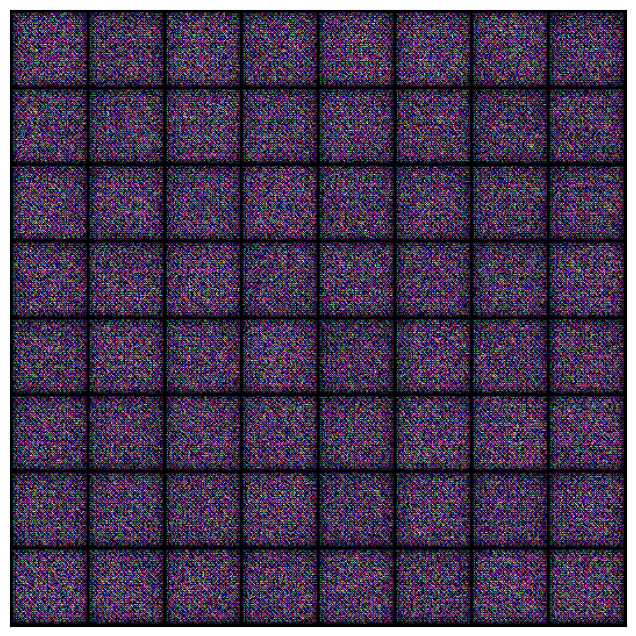

In [177]:
save_samples(0, fixed_latent)

In [178]:
from tqdm.notebook import tqdm
import torch.nn.functional as F

In [179]:
def fit(epochs, lr, start_idx=1):
    torch.cuda.empty_cache()

    # Losses & scores
    losses_g = []
    losses_d = []
    real_scores = []
    fake_scores = []

    # Create optimizers
    opt_d = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.999))
    opt_g = torch.optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.999))

    for epoch in range(epochs):
        for real_images, _ in tqdm(train_dl):
            # Train discriminator
            loss_d, real_score, fake_score = train_discriminator(real_images, opt_d)
            # Train generator
            loss_g = train_generator(opt_g)

        # Record losses & scores
        losses_g.append(loss_g)
        losses_d.append(loss_d)
        real_scores.append(real_score)
        fake_scores.append(fake_score)

        # Log losses & scores (last batch)
        print("Epoch [{}/{}], loss_g: {:.4f}, loss_d: {:.4f}, real_score: {:.4f}, fake_score: {:.4f}".format(
            epoch+1, epochs, loss_g, loss_d, real_score, fake_score))

        # Save generated images
        save_samples(epoch+start_idx, fixed_latent, show=False)

    return losses_g, losses_d, real_scores, fake_scores

In [180]:
lr = 0.0002
epochs = 10

In [181]:
history = fit(epochs, lr)

  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [1/10], loss_g: 3.8965, loss_d: 0.8026, real_score: 0.8573, fake_score: 0.4167
Saving generated-images-0001.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [2/10], loss_g: 5.7189, loss_d: 0.6839, real_score: 0.6208, fake_score: 0.0056
Saving generated-images-0002.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [3/10], loss_g: 6.3823, loss_d: 0.3637, real_score: 0.9376, fake_score: 0.2344
Saving generated-images-0003.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [4/10], loss_g: 3.7281, loss_d: 0.1483, real_score: 0.9313, fake_score: 0.0665
Saving generated-images-0004.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [5/10], loss_g: 4.7658, loss_d: 0.2721, real_score: 0.8222, fake_score: 0.0219
Saving generated-images-0005.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [6/10], loss_g: 3.8465, loss_d: 0.2339, real_score: 0.8566, fake_score: 0.0224
Saving generated-images-0006.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [7/10], loss_g: 6.7543, loss_d: 0.0535, real_score: 0.9661, fake_score: 0.0162
Saving generated-images-0007.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [8/10], loss_g: 9.3137, loss_d: 0.6715, real_score: 0.9979, fake_score: 0.3661
Saving generated-images-0008.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [9/10], loss_g: 7.9323, loss_d: 0.0192, real_score: 0.9904, fake_score: 0.0084
Saving generated-images-0009.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [10/10], loss_g: 7.5607, loss_d: 0.2653, real_score: 0.9832, fake_score: 0.1888
Saving generated-images-0010.png


In [182]:
losses_g, losses_d, real_scores, fake_scores = history

In [183]:
from IPython.display import Image

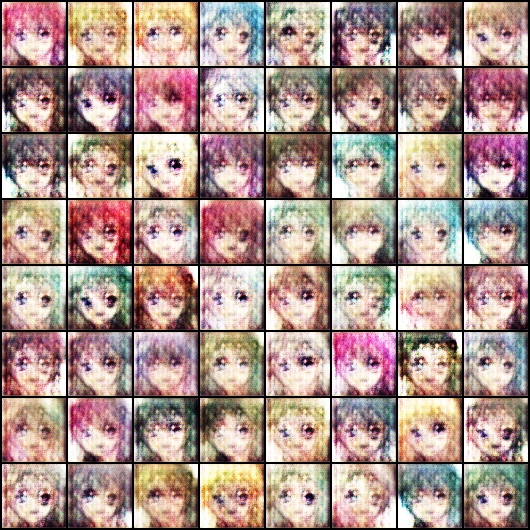

In [184]:
Image('./generated/generated-images-0001.png')

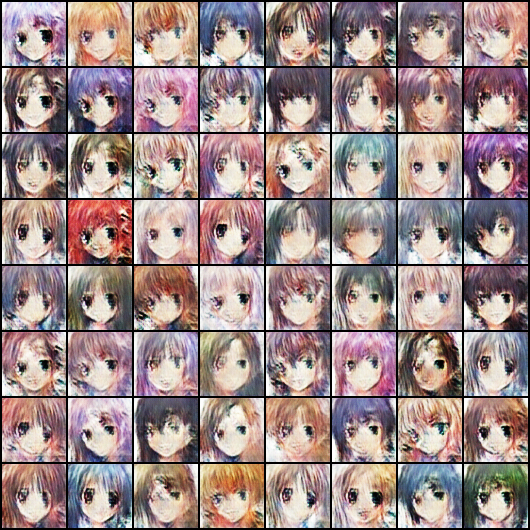

In [185]:
Image('./generated/generated-images-0005.png')